In [44]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import scipy.stats as st

In [137]:
df = pd.read_csv('./creditcard.csv')
df.head()
#Class:- 1 is fraud 0 is no fraud

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [138]:
df.shape

(284807, 31)

In [139]:
df['Class'].value_counts()

,count
Class,
0,284315
1,492


In [140]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [141]:
X= df.drop(columns='Class',axis=1)
Y= df['Class']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=True, stratify=Y, random_state=42)

In [142]:
logit = LogisticRegression()
logit.fit(X_train,Y_train)
yhat = logit.predict(X_test)

print(accuracy_score(Y_test,yhat))

0.9992011090486148


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


###Our model is 99.87% accurate


In [143]:
Y_pred_for_all = logit.predict(X)

In [144]:
Y_pred_for_all = np.array(Y_pred_for_all)
Y = np.array(Y)
df['Y']=Y  #Y total
df['Y_hat']= Y_pred_for_all    #Y_hat unlabelled

In [145]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Y,Y_hat
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,0


In [146]:
def ppi_mean_ci(Y, Yhat, Yhat_unlabeled, alpha=0.05):

    Y = np.array(Y)
    Yhat = np.array(Yhat)
    Yhat_unlabeled = np.array(Yhat_unlabeled)

    # Step 1: Mean of all predictions
    mean_pred = np.mean(np.concatenate([Yhat, Yhat_unlabeled]))

    # Step 2: Bias correction/
    residuals = Y - Yhat
    bias_correction = np.mean(residuals)

    # Step 3: PPI mean estimate
    ppi_mean = mean_pred + bias_correction

    # Step 4: Standard error from residuals
    n = len(Y)
    se = np.std(residuals, ddof=1) / np.sqrt(n)

    # Step 5: Critical value
    z = st.norm.ppf(1 - alpha / 2)

    # Step 6: CI bounds
    ci_lower = ppi_mean - z * se
    ci_upper = ppi_mean + z * se

    return [ci_lower, ci_upper]

In [147]:
import numpy as np
import scipy.stats as st

def classical_mean_ci(Y, alpha=0.05):

    Y = np.array(Y)
    mean_y = np.mean(Y)

    n = len(Y)
    se = np.std(Y, ddof=1) / np.sqrt(n)  # Standard error

    z = st.norm.ppf(1 - alpha / 2)  # Critical value

    ci_lower = mean_y - z * se
    ci_upper = mean_y + z * se

    return [ci_lower, ci_upper]


In [148]:
alpha = 0.05  # 95% confidence level

n_total = 283726  # Total number of labeled examples in your data

ns = np.linspace(500, 5000, 10).astype(int)

num_trials = 100  # Number of trials for each sample size

true_theta = np.mean(Y)

In [149]:
df.shape

(283726, 33)

In [150]:
Y_total = df['Y']  #Y total
Yhat_total= df['Y_hat']#Y_hat unlabelled

In [154]:
results = []
Y_total = np.array(Y_total)
Yhat_total = np.array(Yhat_total)
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        n = ns[i]
        rand_idx = np.random.permutation(n_total)

        _Yhat = Yhat_total[rand_idx[:n]]
        _Y = Y_total[rand_idx[:n]]
        _Yhat_unlabeled = Yhat_total[rand_idx[n:]]

        ppi_ci = ppi_mean_ci(_Y, _Yhat, _Yhat_unlabeled, alpha=alpha)
        classical_ci = classical_mean_ci(_Y, alpha=alpha)

        results.append({"method": "PPI", "n": n, "lower": ppi_ci[0], "upper": ppi_ci[1], "trial": j})
        results.append({"method": "Classical", "n": n, "lower": classical_ci[0], "upper": classical_ci[1], "trial": j})

# Imputation CI (outside loop)
imputed_ci = classical_mean_ci(Yhat_total > 0.5, alpha=alpha)
results.append({"method": "Imputation", "n": np.nan, "lower": imputed_ci[0], "upper": imputed_ci[1], "trial": 0})

df_new = pd.DataFrame(results)
df_new["width"] = df_new["upper"] - df_new["lower"]
df["width"] = df_new["upper"] - df_new["lower"]


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


In [152]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Y,Y_hat,width
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,0,0.011076
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,0,0.013552
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0,0,0.000000
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,0,0.000000
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,0,0.000000


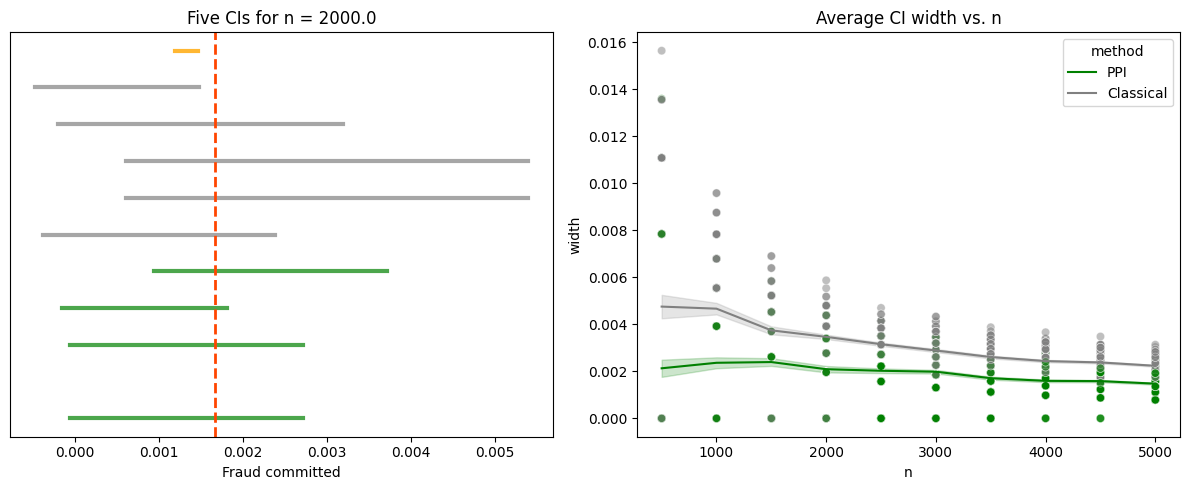

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def make_plots(df, n_idx=3, intervals_xlabel="Fraud committed", true_theta=None):
    """
    Plots:
    1. Five randomly chosen confidence intervals from PPI & Classical methods + Imputation CI.
    2. Average interval width vs. sample size for PPI & Classical methods.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns: ['method','n','lower','upper','width','trial']
    save_path : str
        Path to save the figure (PDF or PNG).
    n_idx : int
        Index in ns to choose for interval plotting (e.g., 3rd sample size).
    intervals_xlabel : str
        Label for x-axis of the CI plot.
    true_theta : float
        True mean (to draw reference line).
    """
    methods = ["PPI", "Classical"]

    # Filter rows for chosen n
    ns_unique = np.sort(df["n"].dropna().unique())
    chosen_n = ns_unique[n_idx]
    df_n = df[df["n"] == chosen_n]

    # Randomly sample 5 intervals per method
    sampled_intervals = df_n.groupby("method").sample(n=5, random_state=42)

    # Imputed interval (only one row)
    df_imputed = df[df["method"] == "Imputation"]

    # --- PLOT ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # -------- Left: Intervals plot --------
    ax = axes[0]
    y_pos = 0
    colors = {"PPI": "green", "Classical": "gray"}

    for method in methods:
        subset = sampled_intervals[sampled_intervals["method"] == method]
        for _, row in subset.iterrows():
            ax.plot([row["lower"], row["upper"]], [y_pos, y_pos],
                    color=colors[method], lw=3, alpha=0.7)
            y_pos += 1

    # Add imputed CI
    for _, row in df_imputed.iterrows():
        ax.plot([row["lower"], row["upper"]], [y_pos, y_pos],
                color="orange", lw=3, alpha=0.8)
    y_pos += 1

    # Add vertical line for true theta
    if true_theta is not None:
        ax.axvline(true_theta, color="orangered", linestyle="--", lw=2)

    ax.set_xlabel(intervals_xlabel)
    ax.set_yticks([])
    ax.set_title(f"Five CIs for n = {chosen_n}")

    # -------- Right: CI Widths vs n --------
    ax = axes[1]
    sns.lineplot(data=df[df["method"].isin(methods)],
                 x="n", y="width", hue="method", errorbar="se", ax=ax,
                 palette={"PPI": "green", "Classical": "gray"})
    sns.scatterplot(data=df[df["method"].isin(methods)],
                    x="n", y="width", hue="method", ax=ax,
                    palette={"PPI": "green", "Classical": "gray"}, legend=False, alpha=0.5)

    ax.set_ylabel("width")
    ax.set_title("Average CI width vs. n")

    plt.tight_layout()
    plt.show()

true_theta = np.mean(Y)
make_plots(df_new, true_theta=true_theta)